In [1]:
import mxnet as mx
import gluoncv

In [2]:
print(mx.__version__)
print(gluoncv.__version__)

1.9.0
0.11.0


In [3]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

In [4]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

detector.reset_class(['person'], reuse_weights=['person'])

[14:34:32] ../src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


88993KB [00:04, 18782.34KB/s]                           


55763KB [00:03, 17143.51KB/s]                           


In [5]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

1562KB [00:01, 891.11KB/s]                          


Shape of pre-processed image: (1, 3, 512, 605)


In [6]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)


In [10]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)


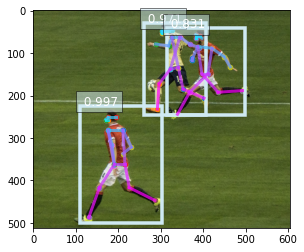

In [11]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()

In [12]:
print(class_IDs.shape, scores.shape, bounding_boxs.shape)

(1, 100, 1) (1, 100, 1) (1, 100, 4)


In [16]:
print(pose_input.shape, upscale_bbox)

(3, 3, 256, 192) [[85.56877040863037, 191.40037536621094, 326.2258996963501, 512], [242.98922729492188, 2.3973588943481445, 424.7693176269531, 274.23713970184326], [291.81422424316406, 17.120450019836426, 521.1643524169922, 272.0488386154175]]


In [21]:
predicted_heatmap.shape

(3, 17, 64, 48)

In [22]:
print(pred_coords.shape, confidence.shape)

(3, 17, 2) (3, 17, 1)


In [26]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord_alpha_pose

In [27]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('alpha_pose_resnet101_v1b_coco', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

216179KB [00:10, 20610.02KB/s]                            


In [28]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.yolo.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

Shape of pre-processed image: (1, 3, 512, 605)


In [29]:
pose_input, upscale_bbox = detector_to_alpha_pose(img, class_IDs, scores, bounding_boxs)


In [33]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord_alpha_pose(predicted_heatmap, upscale_bbox)


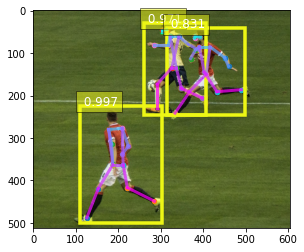

In [34]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()

In [1]:
from __future__ import division

import time, logging, os, math

import numpy as np
import mxnet as mx
from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data import mscoco
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRScheduler
from gluoncv.data.transforms.presets.simple_pose import SimplePoseDefaultTrainTransform
from gluoncv.utils.metrics import HeatmapAccuracy

In [2]:
train_dataset = mscoco.keypoints.COCOKeyPoints('~/.mxnet/datasets/coco',
                                               splits=('person_keypoints_train2017'))


loading annotations into memory...
Done (t=8.61s)
creating index...
index created!


In [14]:
print(train_dataset.joint_pairs)

[[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]


In [15]:
transform_train = SimplePoseDefaultTrainTransform(num_joints=train_dataset.num_joints,
                                                  joint_pairs=train_dataset.joint_pairs,
                                                  image_size=(256, 192), heatmap_size=(64, 48),
                                                  scale_factor=0.3, rotation_factor=40,
                                                  random_flip=True)

In [16]:
batch_size = 32
train_data = gluon.data.DataLoader(
    train_dataset.transform(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=0
)

In [18]:
context = mx.gpu(0)
net = get_model('simple_pose_resnet18_v1b', num_joints=17, pretrained_base=True,
                ctx=context, pretrained_ctx=context)
net.deconv_layers.initialize(ctx=context)
net.final_layer.initialize(ctx=context)

In [19]:
x = mx.nd.ones((1, 3, 256, 192), ctx=context)
net.summary(x)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 256, 192)               0
            Conv2D-1                            (1, 64, 128, 96)            9408
 BatchNormCudnnOff-2                            (1, 64, 128, 96)             256
        Activation-3                            (1, 64, 128, 96)               0
         MaxPool2D-4                             (1, 64, 64, 48)               0
            Conv2D-5                             (1, 64, 64, 48)           36864
 BatchNormCudnnOff-6                             (1, 64, 64, 48)             256
        Activation-7                             (1, 64, 64, 48)               0
            Conv2D-8                             (1, 64, 64, 48)           36864
 BatchNormCudnnOff-9                             (1, 64, 64, 48)             256
       Activation-10        

[14:32:34] ../src/operator/cudnn_ops.cc:292: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable
[14:32:34] ../src/operator/cudnn_ops.cc:292: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


In [20]:
L = gluon.loss.L2Loss()

num_training_samples = len(train_dataset)
num_batches = num_training_samples // batch_size
lr_scheduler = LRScheduler(mode='step', base_lr=0.001,
                           iters_per_epoch=num_batches, nepochs=140,
                           step_epoch=(90, 120), step_factor=0.1)


In [21]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'lr_scheduler': lr_scheduler})

In [34]:
metric = HeatmapAccuracy()

In [35]:
net.hybridize(static_alloc=True, static_shape=True)
for epoch in range(140):
    metric.reset()
    
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=[context], batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=[context], batch_axis=0)
        weight = gluon.utils.split_and_load(batch[2], ctx_list=[context], batch_axis=0)
        
        with ag.record():
            outputs = [net(X) for X in data]
            loss = [L(yhat, y, w) for yhat, y, w in zip(outputs, label, weight)]
            
        for l in loss:
            l.backward()
        trainer.step(batch_size)
        
        metric.update(label, outputs)
        print(metric.get())


[14:50:07] ../src/operator/cudnn_ops.cc:441: Using fallback engine(s) for wgrad float NCHW kernel: [1,1] stride: [1,1] dilate: [1,1] pad: [0,0] num_filter: 17 num_group: 1 workspace: 1024
[14:50:07] ../src/operator/cudnn_ops.cc:441: Using fallback engine(s) for wgrad float NCHW kernel: [4,4] stride: [2,2] dilate: [1,1] pad: [1,1] num_filter: 256 num_group: 1 workspace: 1024
[14:50:09] ../src/operator/cudnn_ops.cc:441: Using fallback engine(s) for wgrad float NCHW kernel: [4,4] stride: [2,2] dilate: [1,1] pad: [1,1] num_filter: 256 num_group: 1 workspace: 1024
[14:50:10] ../src/operator/cudnn_ops.cc:441: Using fallback engine(s) for wgrad float NCHW kernel: [4,4] stride: [2,2] dilate: [1,1] pad: [1,1] num_filter: 256 num_group: 1 workspace: 1024
[14:50:10] ../src/operator/cudnn_ops.cc:441: Using fallback engine(s) for wgrad float NCHW kernel: [3,3] stride: [2,2] dilate: [1,1] pad: [1,1] num_filter: 512 num_group: 1 workspace: 1024
[14:50:10] ../src/operator/cudnn_ops.cc:441: Using fallb

('heatmap_accuracy', 0.014075630252100839)
('heatmap_accuracy', 0.014573197700132684)
('heatmap_accuracy', 0.013164275487602989)
('heatmap_accuracy', 0.013038844851672959)
('heatmap_accuracy', 0.010431075881338367)
('heatmap_accuracy', 0.008692563234448638)
('heatmap_accuracy', 0.007870936553897152)
('heatmap_accuracy', 0.007780005369658686)
('heatmap_accuracy', 0.0069155603285854985)
('heatmap_accuracy', 0.00668984280504372)
('heatmap_accuracy', 0.006415899876242953)
('heatmap_accuracy', 0.006327776442482055)
('heatmap_accuracy', 0.006046701084709885)
('heatmap_accuracy', 0.005614793864373465)
('heatmap_accuracy', 0.0057241344041341876)
('heatmap_accuracy', 0.005847659426335694)
('heatmap_accuracy', 0.005503679460080653)
('heatmap_accuracy', 0.005197919490076173)
('heatmap_accuracy', 0.005039010529412835)
('heatmap_accuracy', 0.0047870600029421935)
('heatmap_accuracy', 0.004559104764706851)
('heatmap_accuracy', 0.0044632809295909424)
('heatmap_accuracy', 0.004269225237000032)
('heatma

KeyboardInterrupt: 